## Imports

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
import PIL
import PIL.Image
import glob
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras import layers
import tensorflow_addons as tfa

In [27]:
train_directory = r'C:\Users\Kostas\Desktop\GIMA\Module_7\Data\PEP725\After_2016_sent_from_PEP725\pep725_outputs\pep725_high_count_days\checking_data\train'
test_directory = r'C:\Users\Kostas\Desktop\GIMA\Module_7\Data\PEP725\After_2016_sent_from_PEP725\pep725_outputs\pep725_high_count_days\checking_data\test'

In [28]:
data_dir = pathlib.Path(train_directory).with_suffix('')

In [29]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

13


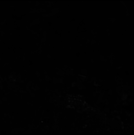

In [34]:
DBL = list(data_dir.glob('DBL/*'))
PIL.Image.open(str(DBL[3]))

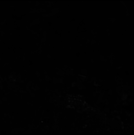

In [36]:
EC = list(data_dir.glob('EC/*.png'))
PIL.Image.open(str(EC[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## Data preparation

In [37]:
# Using a test directory to see if I can input them into the model. The directory images are not correctly classified.
# This is just a test to see if it's possible to insert them.
train_dataset = tf.keras.utils.image_dataset_from_directory(
            train_directory,
            labels='inferred',
            label_mode='int',
            color_mode='grayscale',
            image_size=(800, 800)
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(800, 800)
)

# It seems that image_dataset_from_directory does not accept .tif images
# I will try with a deprecated function, ImageDataGenerator.

Found 13 files belonging to 3 classes.
Found 11 files belonging to 3 classes.


In [68]:
print(train, test)
print(type(train_dataset))

<BatchDataset element_spec=(TensorSpec(shape=(None, 800, 800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 800, 800, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [40]:
class_names = train_dataset.class_names # return type: list
print(class_names)
type(class_names)

['DBL', 'EC', 'M']


list

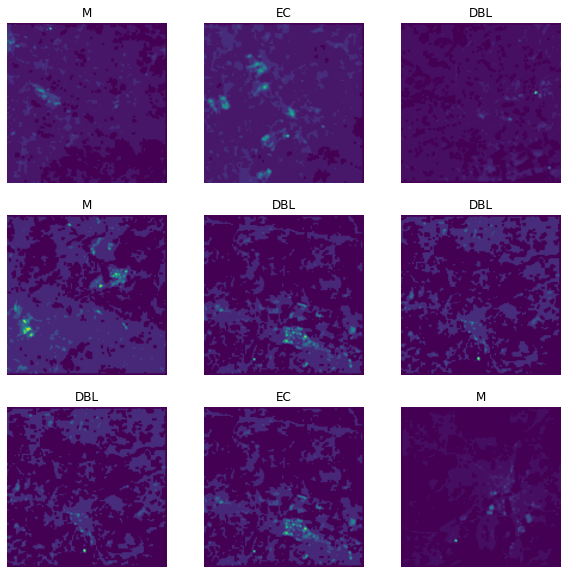

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        [plt.axis("off")]

In [73]:
type(train_dataset.unbatch())

tensorflow.python.data.ops.dataset_ops._UnbatchDataset

---------------------------------------------------------
Trying to use ImageDataGenerator

In [8]:
# I think that this function also does some data augmentation while importing the images.
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()
train_image_generator = train_datagen.flow_from_directory(
    train_directory,
    batch_size=16,
    color_mode="grayscale",
    target_size=(256,256),
    class_mode=None,
    shuffle=True,
)

test_image_generator = train_datagen.flow_from_directory(
    test_directory,
    batch_size=16,
    color_mode="grayscale",
    target_size=(256,256),
    class_mode=None,
    shuffle=True,
)

Found 13 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


c:\Users\Kostas\anaconda3\envs\vit\lib\site-packages\keras_preprocessing\image\utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [ ]:
train_image_generator.shape

AttributeError: 'DirectoryIterator' object has no attribute 'shape'

--------------------------------------------------

Test with a CNN to see if it works

In [58]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [61]:
model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=10
)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.0146 - accuracy: 0.3077 - val_loss: 1.0874 - val_accuracy: 0.3636
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.8851 - accuracy: 0.6923 - val_loss: 1.0683 - val_accuracy: 0.4545
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 0.7980 - accuracy: 0.6154 - val_loss: 1.1068 - val_accuracy: 0.2727
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.6482 - accuracy: 0.6923 - val_loss: 1.0566 - val_accuracy: 0.3636
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.4613 - accuracy: 0.9231 - val_loss: 1.0980 - val_accuracy: 0.3636
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.3450 - accuracy: 0.9231 - val_loss: 1.1543 - val_accuracy: 0.1818
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.2676 - accuracy: 0.9231 - val_loss: 1.4478 - val_accuracy: 0.3636
Epoch 8/10
1/1 [=========================

## Vision Transformer

In [ ]:
num_classes = 3
input_shape = (800, 800, 1)

# I should add the dataset here to read it
# I should also add a segment that resizes the input images to the desired XY dimensions

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"Train data shapes \nx_train: {x_train.shape} \ty_train: {y_train.shape}")
print(f"Test data shapes \nx_test: {x_test.shape} \ty_test: {y_test.shape}")

## Configuring hyperparameters

In [62]:
# learning rate will need a few tests. I am leaving the suggested one here
learning_rate = 0.001

# The same applies for weight decay
weight_decay = 0.0001

# The batch size will probably need some adjusting. I think that it should be less.
batch_size = 256
num_epochs = 100

# Resizing the input images. To be decided which size to use
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extracted from the input images

# This should stay as it is.
num_patches = (image_size // patch_size) ** 2

# The linear projection dimension. It is used in many steps along the process
projection_dim = 64

# The number of Attention Heads. I will start with 3 because the processing grows a lot by tweaking them.
num_heads = 3


transformer_units = [
    projection_dim * 2,
    projection_dim,
]  

# Size of the transformer layers
transformer_layers = 8

# Classifier (last step)
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

## Building the different components of the model

### Multilayer Perceptron (MLP)

In [63]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Patch creation

Creating a class for the patch creation which will be used in each input image

In [67]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1], # The stride controls the overlapping of patches
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Displaying a patch

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Patch encoder

Does the following:
1. Project the patches with a linear projection
2. Adds a token
3. Adds positional embedding to the patches

In [65]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

NameError: name 'layers' is not defined

## Building the ViT model

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    # augmented = data_augmentation(inputs) --> Didn't add data augmentation yet
    # Create patches.
    patches = Patches(patch_size)#(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):

        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model